# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2 toc-item"><a href="#Initial-Thoughts" data-toc-modified-id="Initial-Thoughts-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initial Thoughts</a></div><div class="lev2 toc-item"><a href="#Initial-Exploration-&amp;-Sanity-Checks" data-toc-modified-id="Initial-Exploration-&amp;-Sanity-Checks-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Initial Exploration &amp; Sanity Checks</a></div><div class="lev3 toc-item"><a href="#Proportions-of-categorical-variables" data-toc-modified-id="Proportions-of-categorical-variables-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Proportions of categorical variables</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-Random-distribution-amongst-test/control" data-toc-modified-id="Sanity-check:-Random-distribution-amongst-test/control-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Sanity check: Random distribution amongst test/control</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-what-are-the-overall-conversion-rates-as-a-population?" data-toc-modified-id="Sanity-check:-what-are-the-overall-conversion-rates-as-a-population?-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Sanity check: what are the overall conversion rates as a population?</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-conversion-rates-by-group?" data-toc-modified-id="Sanity-check:-conversion-rates-by-group?-124"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Sanity check: conversion rates by group?</a></div><div class="lev3 toc-item"><a href="#Quick-check:-Expected-Revenue" data-toc-modified-id="Quick-check:-Expected-Revenue-125"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Quick check: Expected Revenue</a></div><div class="lev1 toc-item"><a href="#Model-1:-Naïve-Comparison" data-toc-modified-id="Model-1:-Naïve-Comparison-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model 1: Naïve Comparison</a></div><div class="lev2 toc-item"><a href="#Modelling-Choices" data-toc-modified-id="Modelling-Choices-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Modelling Choices</a></div><div class="lev2 toc-item"><a href="#Model-Specification" data-toc-modified-id="Model-Specification-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model Specification</a></div><div class="lev2 toc-item"><a href="#Model-Results" data-toc-modified-id="Model-Results-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model Results</a></div><div class="lev3 toc-item"><a href="#Conversion-Rate" data-toc-modified-id="Conversion-Rate-231"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Conversion Rate</a></div><div class="lev3 toc-item"><a href="#Value-Per-Customer" data-toc-modified-id="Value-Per-Customer-232"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Value Per Customer</a></div><div class="lev2 toc-item"><a href="#Model-Interpretation" data-toc-modified-id="Model-Interpretation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Model Interpretation</a></div><div class="lev1 toc-item"><a href="#Model-2:-Deeper-Dive" data-toc-modified-id="Model-2:-Deeper-Dive-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model 2: Deeper Dive</a></div><div class="lev2 toc-item"><a href="#Question:-Are-there-duplicate-users?" data-toc-modified-id="Question:-Are-there-duplicate-users?-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Question: Are there duplicate users?</a></div><div class="lev2 toc-item"><a href="#Question:-Are-there-differences-between-source-in-conversion-rate?" data-toc-modified-id="Question:-Are-there-differences-between-source-in-conversion-rate?-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Question: Are there differences between <code>source</code> in conversion rate?</a></div><div class="lev2 toc-item"><a href="#Modelling-Choices" data-toc-modified-id="Modelling-Choices-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Modelling Choices</a></div><div class="lev2 toc-item"><a href="#Model-Specification" data-toc-modified-id="Model-Specification-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Model Specification</a></div><div class="lev2 toc-item"><a href="#Model-Results" data-toc-modified-id="Model-Results-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Model Results</a></div><div class="lev1 toc-item"><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></div>

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import patsy as ps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_18eb1_qe.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


# Introduction

In this notebook, we are analyzing the results of an A/B test. Personally, I don't like the specialized terminology, so I'm going to refer to this test as a "control-vs-test" experiment. 

The control group was exposed to one price of the software (\$39), and the test group was exposed to the other price of the software (\$59). 

The goal of this analysis is to see whether increasing the price might increase revenue.

Let's take a look at the data provided. Firstly, we have the `test_results.csv` file.

In [2]:
results_df = pd.read_csv('data/test_results.csv')
results_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


## Initial Thoughts

Some initial thoughts about the contents of `test_results.csv`. 

1. The most important columns are "`test`" (correlated with "`price`"), and "`converted`", which is "whether the customer bought the software or not". 
1. There may be a confounding factor beyond price, which includes iOS, device, and source. I'm not sure which yet, but we can model it.

## Initial Exploration & Sanity Checks

To get a feel for the data, let's do some exploratory analysis.

### Proportions of categorical variables

Let's first plot the proportions of each categorical variable: `source`, `device`, `operative_system`.

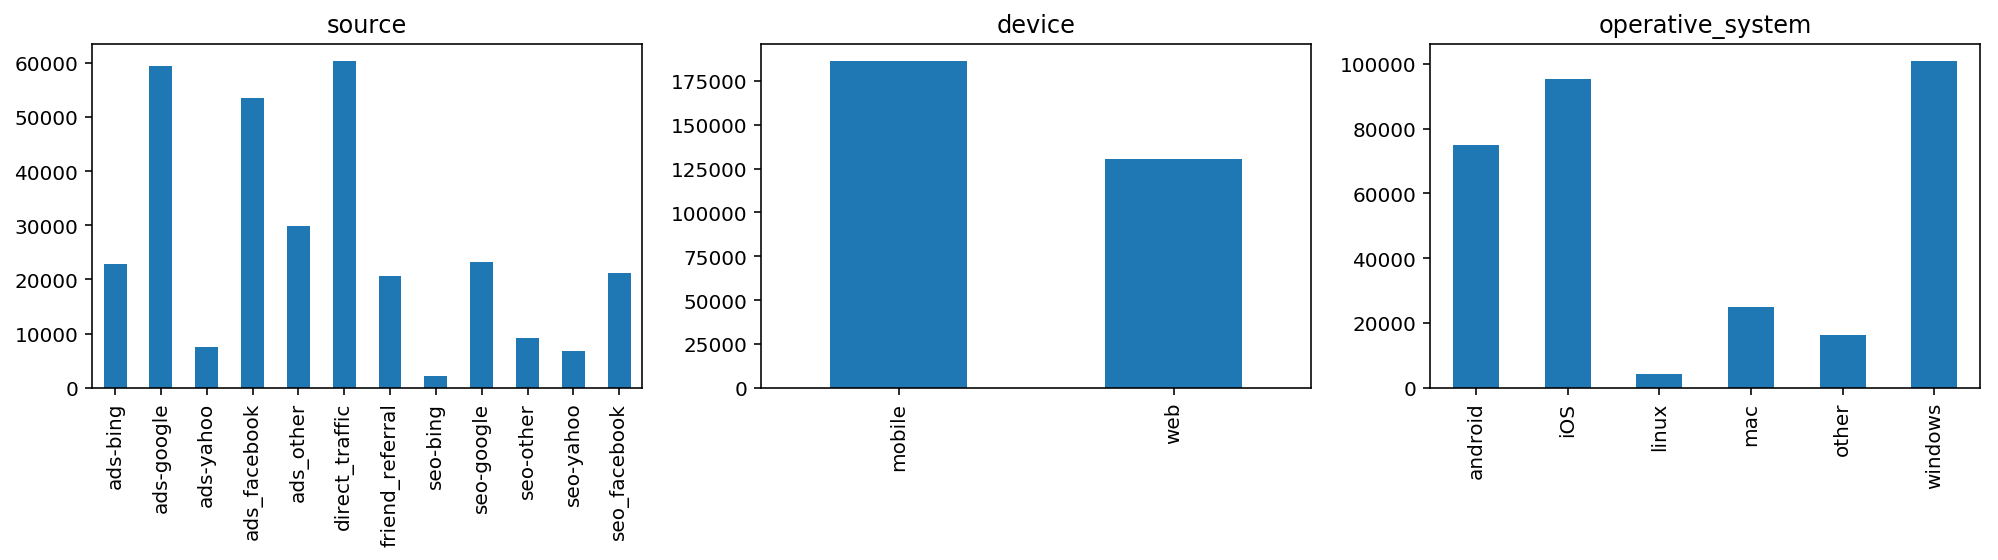

In [3]:
fig = plt.figure(figsize=(14,4))

gs = GridSpec(nrows=1, ncols=3)
factors = ['source', 'device', 'operative_system']

for i, factor in enumerate(factors):
    ax = fig.add_subplot(gs[i])
    results_df.groupby(factor).count()['converted'].plot(kind='bar', ax=ax)
    ax.set_xlabel('')
    ax.set_title(factor)

plt.tight_layout()

### Sanity check: Random distribution amongst test/control

Before we go on, we know that the test groups were randomly split into 66% control, 33% test, which is roughly 2:1. Let's make sure that these proportions are maintained when we look at each grouping of the data.

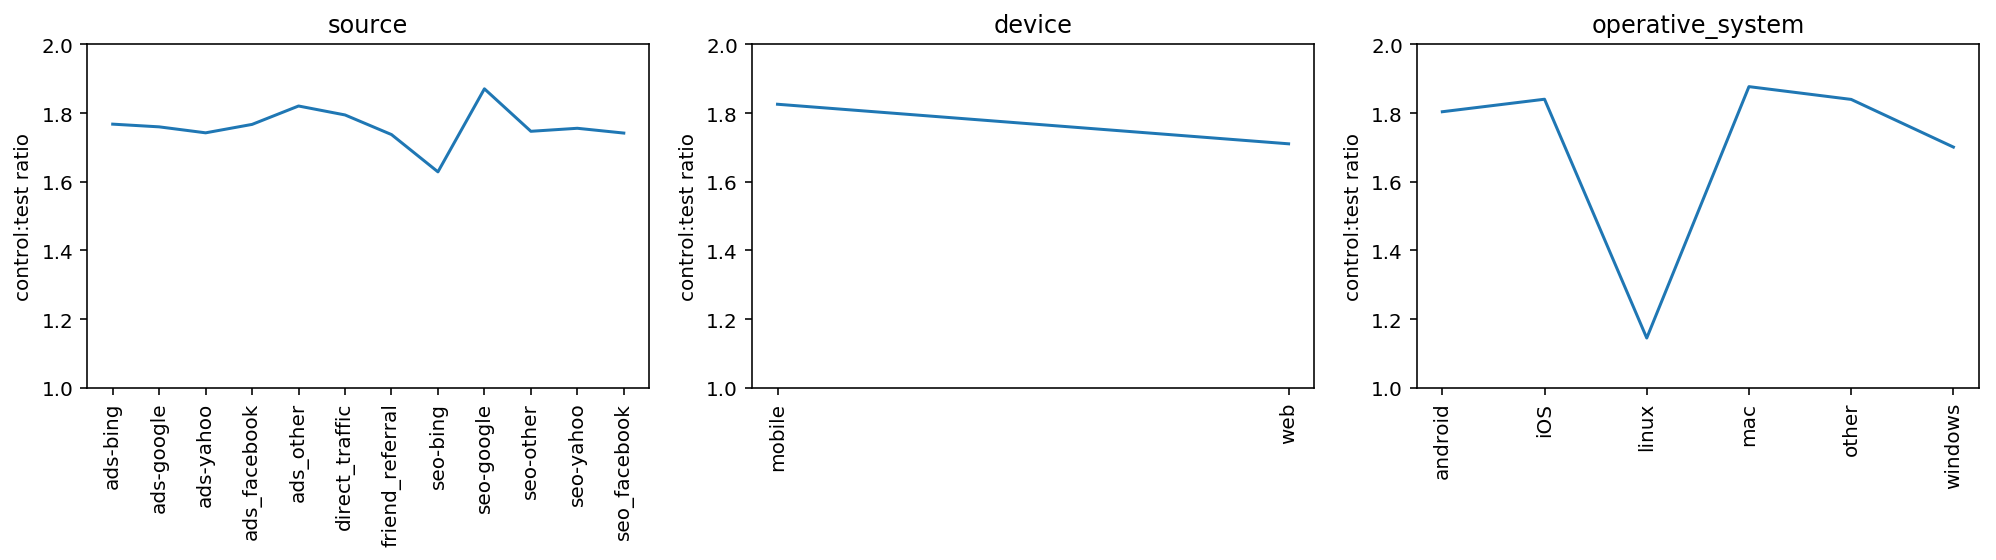

In [4]:
fig = plt.figure(figsize=(14,4))
gs = GridSpec(1, 3)
for i, factor in enumerate(factors):
    ax = fig.add_subplot(gs[i])
    data = []
    grps = []
    for g, d in results_df.groupby(factor):
        n_control = len(d[d['test'] == 0])
        n_test = len(d[d['test'] == 1])

        grps.append(g)
        data.append(n_control/n_test)        
    ax.plot(range(len(grps)), data)
    ax.set_xticks(range(len(grps)))
    ax.set_xticklabels(grps, rotation=90)
    ax.set_ylim(1, 2)
    ax.set_ylabel('control:test ratio')
    ax.set_title(factor)
plt.tight_layout()

From this analysis, we see that the group `linux` has the lowest control:test ratio. All other grouping of the data more or less preserves the control/test ratio of ~1.8, which is close enough for our purposes.

I don't think I'll be necessary to exclude the Linux group. My initial thoughts right now are that if we use a hierarchical Bayesian model, we can pool together the groups somehow and the effect of imbalanced control vs. test group might be mitigated.

### Sanity check: what are the overall conversion rates as a population?

In [5]:
conv_rate_population = \
    len(results_df[results_df['converted'] == 1]) / len(results_df)
conv_rate_population

0.018333333333333333

The conversion rate of 0.018 is very low. The vast majority of people don't buy software.

### Sanity check: conversion rates by group?

In [6]:
is_test = (results_df['test'] == 1)
is_ctrl = (results_df['test'] == 0)

is_conv = (results_df['converted'] == 1)

n_test = len(results_df[is_test])
n_ctrl = len(results_df[is_ctrl])

test_conv = results_df[is_test & is_conv]
ctrl_conv = results_df[is_ctrl & is_conv]

ctrl_rate = len(ctrl_conv)/n_ctrl
test_rate = len(test_conv)/n_test

Here's a summary of the data.

In the control group, we have {{ n_ctrl }} samples taken, {{ len(ctrl_conv) }} conversions, giving a {{ ctrl_rate * 100 }}% conversion rate.

In the test group, we have {{ n_test }} samples taken, {{ len(test_conv) }} conversions, giving a {{ test_rate * 100 }}% conversion rate.

At first glance, it may seem like we don't want to increase the price, so let's quickly check whether total revenue is impacted.

### Quick check: Expected Revenue

In [7]:
test_revenue = test_rate * 59
ctrl_revenue = ctrl_rate * 39

Expected test group revenue is \${{ test_revenue }} per user.

Expected control group revenue is \${{ ctrl_revenue }} per user.

# Model 1: Naïve Comparison

We are going to do some modelling using PyMC3 to figure out whether we expect more revenue from the \$59 price group compared to the \$39 price group.

## Modelling Choices

Firstly, we have 1 vs. 0 for the outcome for each group. Let's do the simple thing by assuming that the $ p $ for each group, $ p_{test} $ and $ p_{ctrl} $ are estimated independently, and that they're not drawn from some common pool like it might be estimated in a hierarchical model.

Secondly, let's estimate the uncertainty around $ p_{test} $ and $ p_{ctrl} $, and deterministically figure out the uncertainty in the expected revenue.

Thirdly, let's place uninformative Uniform priors on $ p_{test} $ and $ p_{ctrl} $, because indeed I didn't know anything about each $ p $ before seeing the data.

## Model Specification

Here, I implement the model in PyMC3.

In [8]:
with pm.Model() as model:
    p_test = pm.Uniform('p_test', 0, 1)
    p_ctrl = pm.Uniform('p_ctrl', 0, 1)
    
    like_test = pm.Bernoulli('like_test', 
                             p=p_test, 
                             observed=results_df[is_test]['converted'].values)
    like_ctrl = pm.Bernoulli('like_ctrl', 
                             p=p_ctrl,
                             observed=results_df[is_ctrl]['converted'].values)
    
    test_dollar = pm.Deterministic('test_dollar', p_test * 59)
    ctrl_dollar = pm.Deterministic('ctrl_dollar', p_ctrl * 39)

In [9]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 33,439:   5%|▌         | 10834/200000 [00:11<03:15, 967.03it/s]   
Convergence archived at 10900
Interrupted at 10,900 [5%]: Average Loss = 92,969
100%|██████████| 2500/2500 [00:16<00:00, 154.58it/s]


## Model Results

Let's take a look at the results.

### Conversion Rate

Firstly, let's look at the posterior distribution of the values of `p_test` and `p_ctrl`, which are the conversion rates for the test and control groups respectively.

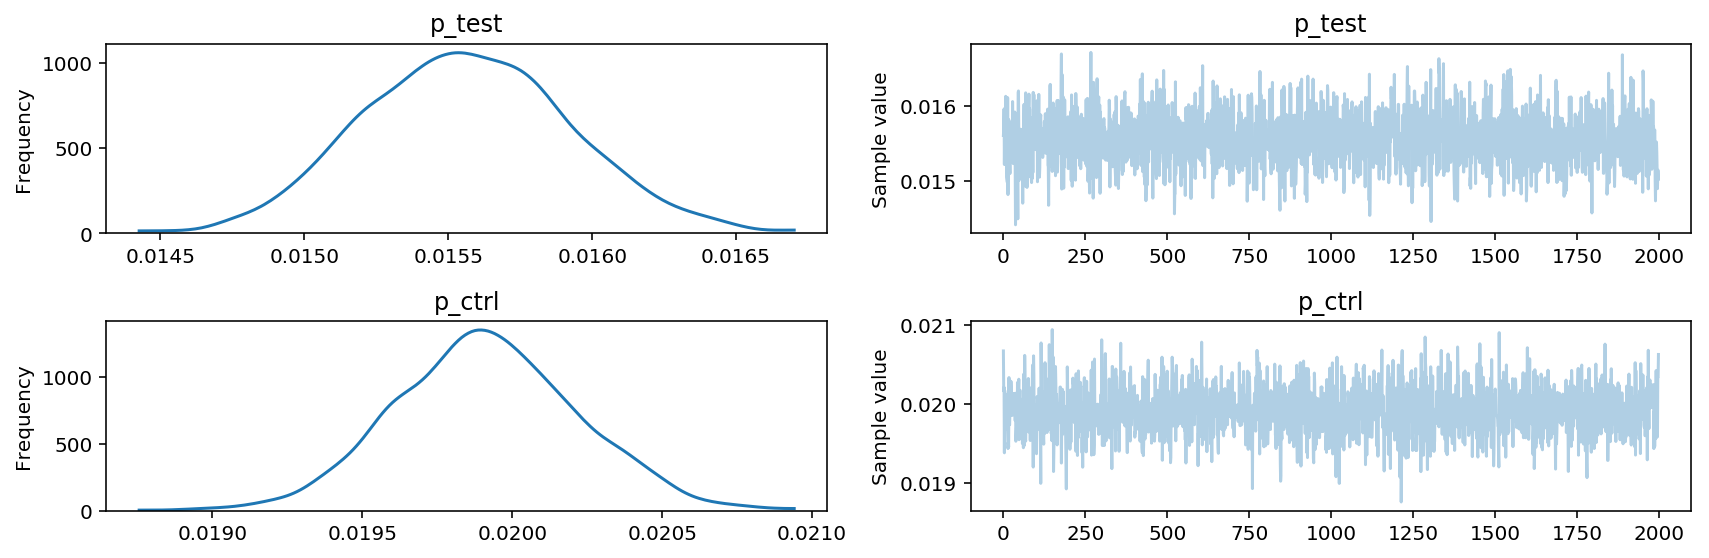

In [13]:
pm.traceplot(trace, varnames=['p_test', 'p_ctrl'])
plt.show()

### Value Per Customer

Next, let's look at the posterior distributions of the expected income per customer.

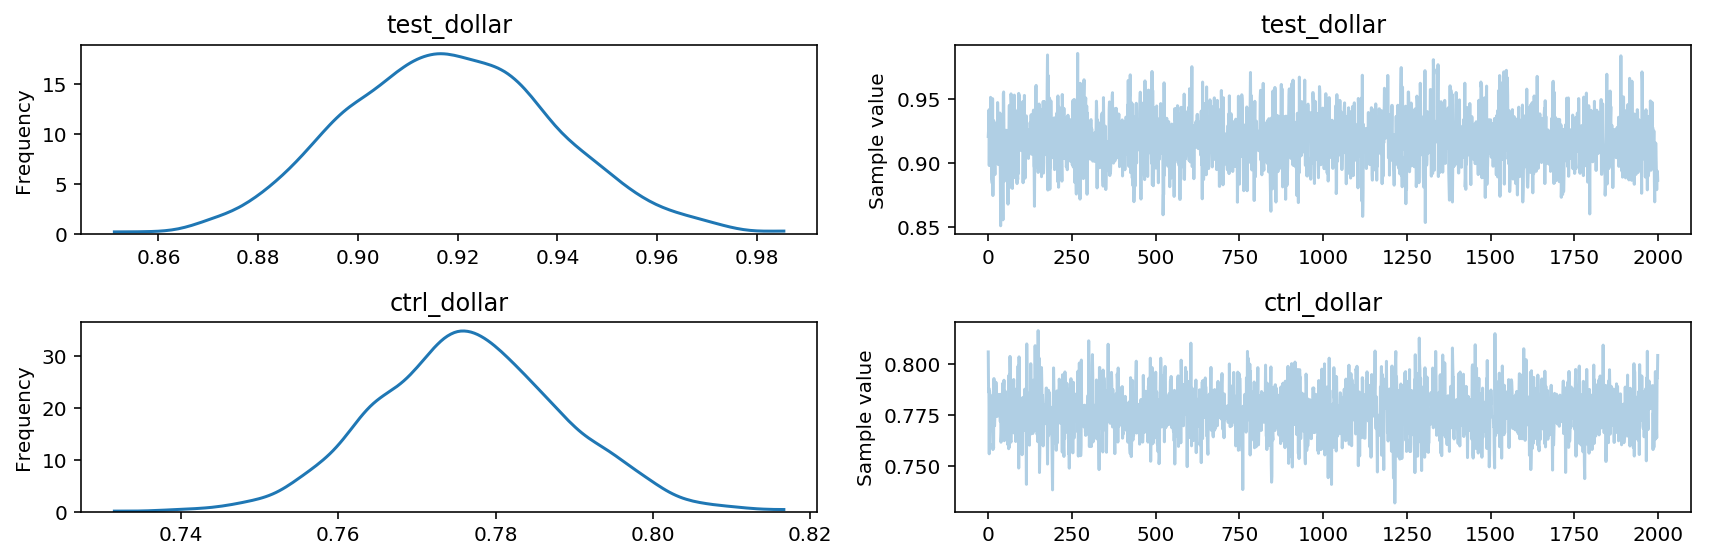

In [14]:
pm.traceplot(trace, varnames=['test_dollar', 'ctrl_dollar'])
plt.show()

We can also look at the posterior distribution summary.

In [15]:
pm.summary(trace, varnames=['test_dollar', 'ctrl_dollar'])


test_dollar:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.918            0.021            0.000            [0.878, 0.960]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.879          0.904          0.918          0.932          0.961


ctrl_dollar:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.776            0.012            0.000            [0.754, 0.799]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.754          0.769          0.776          0.784          0.800



In [16]:
# Percentiles
t_lower, t_med, t_upper = np.round(
    np.percentile(trace['test_dollar'], [2.5, 50, 97.5]), 2)
c_lower, c_med, c_upper = np.round(
    np.percentile(trace['ctrl_dollar'], [2.5, 50, 97.5]), 2)

In [17]:
c_med

0.78000000000000003

## Model Interpretation

Without the price increase, each customer is expected to yield \${{ c_med }}, with a lower bound of \${{ c_lower }} and an upper bound of \${{ c_upper }}.

With the price increase, each customer is expected to yield \${{ t_med }}, with a lower bound of \${{ t_lower }} and an upper bound of \${{ t_upper }}.

The two distributions do not overlap, meaning that we have a high probability of increasing revenue on a per-customer basis.

# Model 2: Deeper Dive

Compared to the naive model, let's try incorporating some more data to see if the conclusions change.

Firstly, one thing we didn't check earlier on was whether there are duplicate users listed. This would violate the i.i.d. assumption baked into the naive model. Let's see if this is true.

## Question: Are there duplicate users?

In [18]:
len(results_df['user_id']), len(set(results_df['user_id'].values))

(316800, 316800)

There are {{ len(results_df['user_id']) }} entries in the database, and there are {{ len(set(results_df['user_id'].values)) }} unique users. These are the same. Thus there are no duplicate users recorded. Thus, we can consider each sample to be independent of each other.

## Question: Are there differences between `source` in conversion rate?

If we group users by their `source`, is there a difference between the `source`s w.r.t. conversion rate?

In [19]:
# Grouped by source, looking at control group, comparing converted vs.
# non-converted.
src_ctrl_conv = results_df[is_conv & is_ctrl].groupby('source').count()
src_ctrl_notc = results_df[~is_conv & is_ctrl].groupby('source').count()

# Compute control conversion rate ('cr') grouped by source
src_ctrl_cr = src_ctrl_conv['converted'] / (src_ctrl_conv['converted'] 
                                            + src_ctrl_notc['converted'])
src_ctrl_cr.sort_values()

source
ads-bing           0.013348
direct_traffic     0.013545
ads_other          0.015401
ads-yahoo          0.016812
seo_facebook       0.017445
seo-other          0.017490
seo-google         0.017547
seo-yahoo          0.019482
ads-google         0.022554
ads_facebook       0.023666
seo-bing           0.029985
friend_referral    0.041721
Name: converted, dtype: float64

The highest conversion rate comes from `friend_referral`, followed by `seo-bing`, `ads_facebook`, `ads-google`.

In [20]:
# Grouped by source, looking at test group, comparing converted vs.
# non-converted.
src_test_conv = results_df[is_conv & ~is_ctrl].groupby('source').count()
src_test_notc = results_df[~is_conv & ~is_ctrl].groupby('source').count()
src_test_cr = src_test_conv['converted'] / (src_test_conv['converted'] 
                                            + src_test_notc['converted'])
src_test_cr.sort_values()

source
ads-bing           0.009560
direct_traffic     0.010094
seo-yahoo          0.010463
ads-yahoo          0.011212
seo-other          0.012459
ads_other          0.012462
seo-bing           0.013431
seo_facebook       0.013576
seo-google         0.015979
ads_facebook       0.016842
ads-google         0.019614
friend_referral    0.033466
Name: converted, dtype: float64

Essentially the same ranking for conversion rate. `friend_referral`, followed by `ads-google`, then `ads_facebook`.

## Modelling Choices

We are going to do a multiple-group BEST model to estimate the conversion rate `p` for each of these groups. We are getting into smaller numbers here, so we'll do some hierarchical pooling to help account for small(er) sample sizes. (In the event that large numbers are still at play, the data will update the posteriors themselves.) This is effectively an "empirical Bayes" approach, I think.

## Model Specification

We implement a hierarchical model. For each source class, we assume that each $ p $ is drawn from a $ \beta $ distribution with parameters $ \alpha=1 $ and $ \beta=55 $, which reflects our empirical knowledge of the population conversion rate. We will observe "shrinkage" towards the population mean for classes that have lower sample sizes.

The model is specified as such:

- $ p_{test, grp} \sim \beta(1, 55) $
- $ p_{ctrl, grp} \sim \beta(1, 55) $
- $ likelihood_{test, grp} \sim Bernoulli(p_{test, grp}) $
- $ likelihood_{ctrl, grp} \sim Bernoulli(p_{ctrl, grp}) $

In addition to the above, we implement some deterministic transformations.

- $ test\_dollar = p_{test, grp} * 59 $ 
    - This is the dollar value of each customer at the tested price point, for each advertising group.
- $ ctrl\_dollar = p_{ctrl, grp} * 39 $
    - This is the dollar value of each customer at the control price point, for each advertising group.
- $ test\_ctrl\_ratio = \frac{test\_dollar}{ctrl\_dollar} $
    - This is the ratio of the dollar value of each customer at the tested price point over the control price point. 
        - A value > 1 indicates that for the advertising group, each customer will be worth more at the tested price point than at the control price point.
        - A value < 1 indicates that for the advertising group, each customer will be worth less at the tested price point than at the control price point.

In [60]:
# Make classes into indices
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(results_df['source'])
results_df['source_idx'] = le.transform(results_df['source'])

results_df[is_ctrl]['source_idx'].values

array([3, 8, 0, ..., 5, 1, 6])

In [71]:
with pm.Model() as hierarchical_model:
    # Prior specification.
    p_test = pm.Beta('p_test', alpha=1, beta=55, shape=len(le.classes_))  # approximates population p 
    p_ctrl = pm.Beta('p_ctrl', alpha=1, beta=55, shape=len(le.classes_))
    
    p_test_ind = p_test[results_df[is_test]['source_idx'].values]
    p_ctrl_ind = p_ctrl[results_df[~is_test]['source_idx'].values]
    
    # Likelihood function.
    like_test = pm.Bernoulli('like_test', p=p_test_ind, observed=results_df[is_test]['converted'])
    like_ctrl = pm.Bernoulli('like_ctrl', p=p_ctrl_ind, observed=results_df[~is_test]['converted'])
    
    # Deterministic transforms.
    test_dollar = pm.Deterministic('test_dollar', p_test * 59)
    ctrl_dollar = pm.Deterministic('ctrl_dollar', p_ctrl * 39)
    
    test_ctrl_ratio = pm.Deterministic('test_ctrl_ratio', test_dollar / ctrl_dollar)

In [72]:
with hierarchical_model:
    hierarchical_trace = pm.sample(100000, step=pm.Metropolis())

100%|██████████| 100500/100500 [02:27<00:00, 683.54it/s]


Let's inspect the traces for convergence.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ae1c3208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6adf0ac18>]], dtype=object)

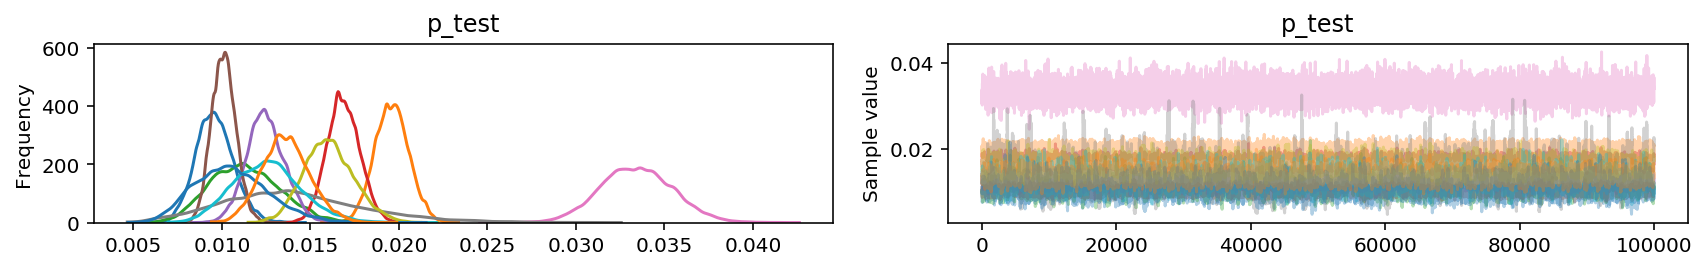

In [73]:
pm.traceplot(hierarchical_trace, varnames=['p_test'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ade412e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6addce3c8>]], dtype=object)

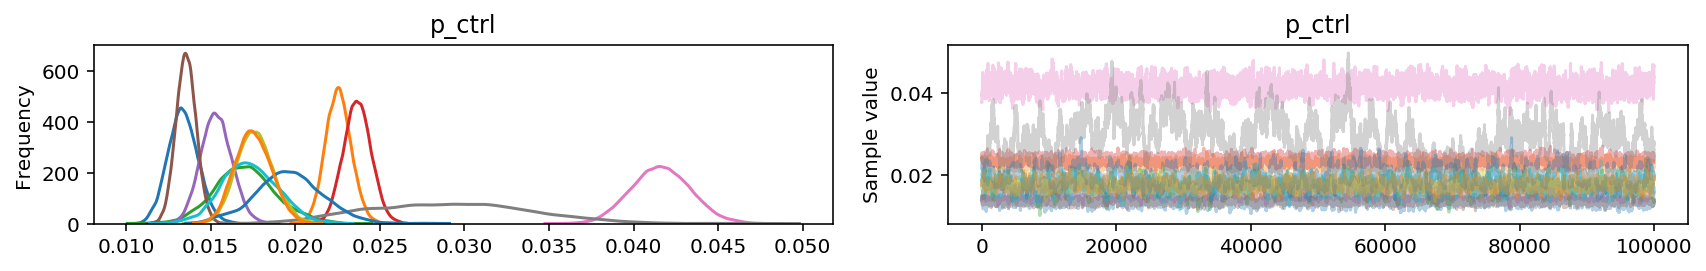

In [74]:
pm.traceplot(hierarchical_trace, varnames=['p_ctrl'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6adcf0e80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6adb8afd0>]], dtype=object)

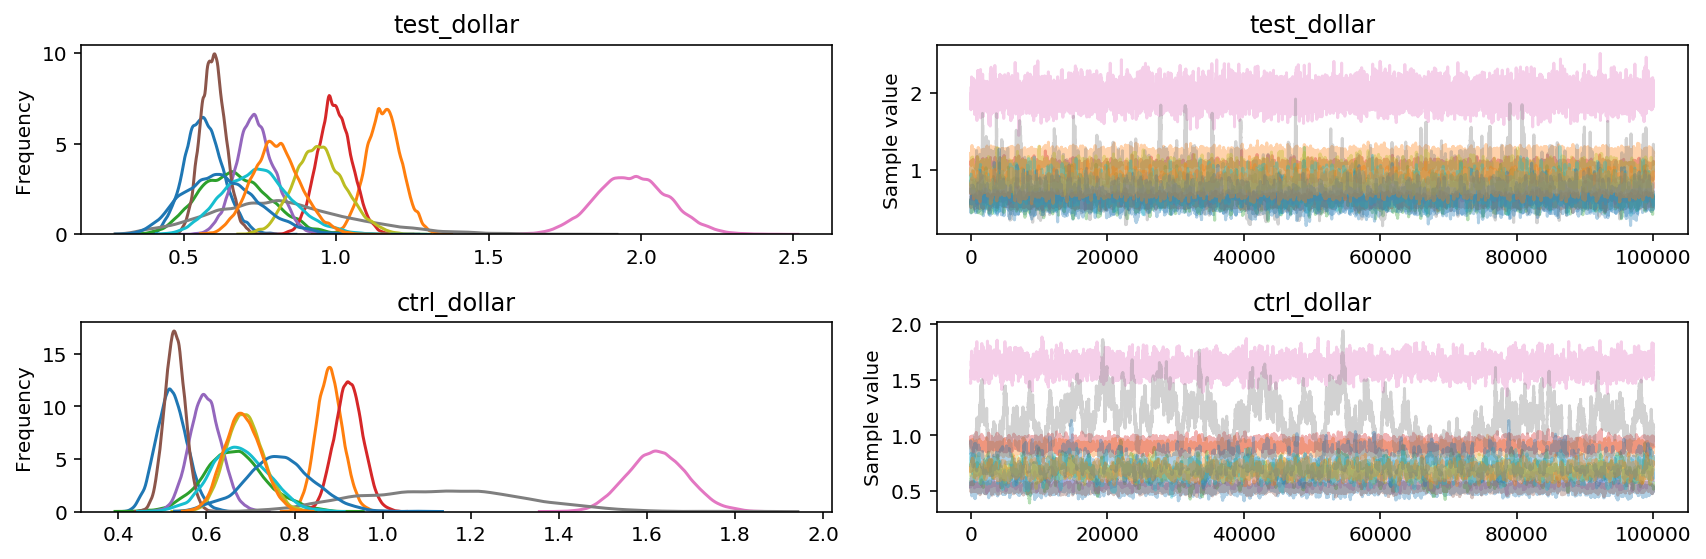

In [75]:
pm.traceplot(hierarchical_trace, varnames=['test_dollar', 'ctrl_dollar'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ad988c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ad9b7b00>]], dtype=object)

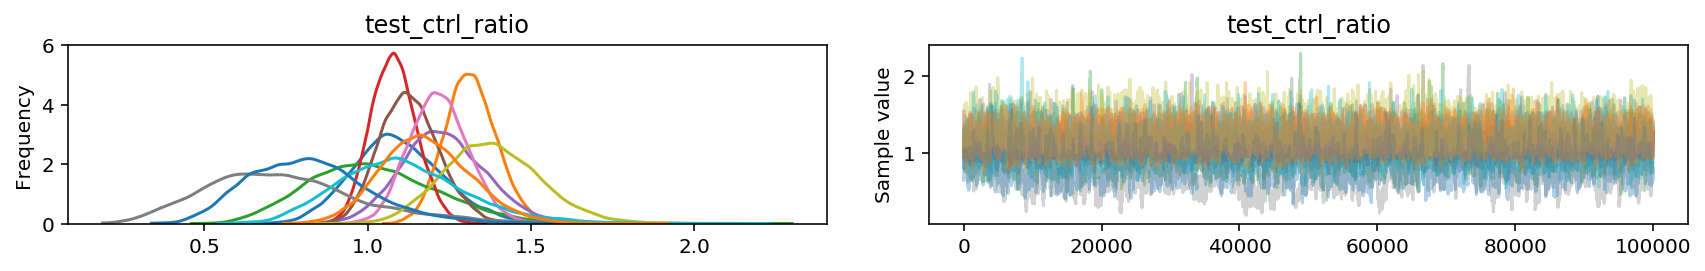

In [76]:
pm.traceplot(hierarchical_trace, varnames=['test_ctrl_ratio'])

MCMC sampling looks good. I'm glad we can take tons of samples very quickly using the Metropolis sampler. There's no trend in the traces either.

## Model Results

Let's look at which routes would be productive for the company's advertising budget. The key that we're looking for is a test/control ratio greater than 1 - these are the routes one would want to target for advertising after raising the price.

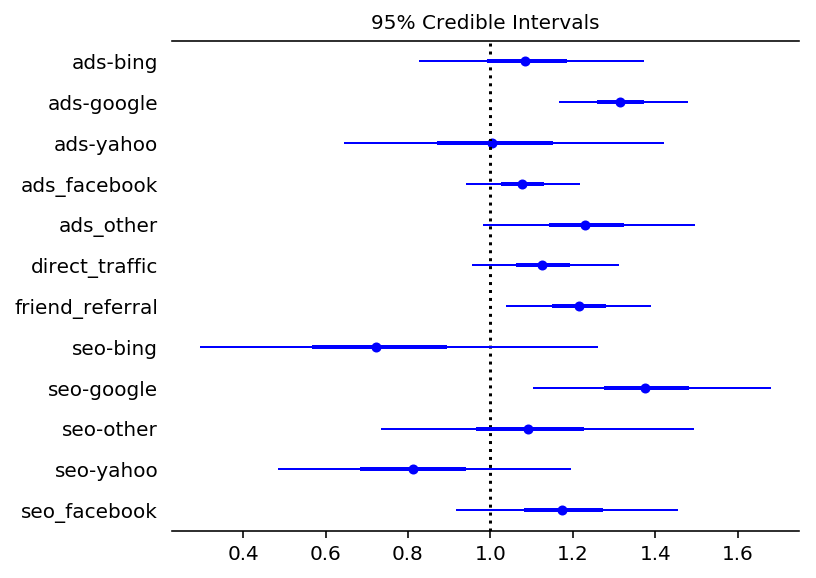

In [80]:
pm.forestplot(hierarchical_trace, varnames=['test_ctrl_ratio'], vline=1.0, ylabels=le.classes_)

# Conclusions

1. Raising the price is a good idea for raising revenue, as shown by the expected per customer.
1. Raising the price is not necessarily a good idea for raising market share, though, as shown by lowered conversion rates.
1. If prices are raised, target advertising to Google & Facebook, and implement discounts for friend referrals, as shown by the test/control ratio analysis.